# Transfer Learning on the Intel Image Dataset with MobileNetv2 and VGG16

In this notebook we see the application of transfer learning to perform image classification on the Intel Image Classification Dataset (link to dataset - https://www.kaggle.com/puneet6060/intel-image-classification). Make sure you have loaded the dataset (using Add data in the top right corner) before commencing with this notebook. In this notebook we will build and fit 2 models based on different pre-trained models to perform the task at hand. The pretrained models that will be used here are MobileNet_v2 and VGG_16 with ImageNet weights. At the end we will compare and contrast between these models based on their performances on some pre-decided metrics.

### Making the necessary imports

In [1]:
import shutil
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import Callback
from scikitplot.metrics import confusion_matrix
import itertools

import yaml
import h5py

import seaborn as sns
sns.set()

### Initializing the seeds for numpy and tensorflow.
This is done in order to ensure reproducable results. However some discrepencies might still occur due to randomness from a third-party library, GPU or from a sophisticated model.

In [2]:
from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [3]:
test_dir = '../input/intel-image-classification/seg_test/seg_test/'

We'll need to move some images from train to test set, but the ../input directory is read-only. So we'll copy it to the 'Output' directory.

In [4]:
train_dir = './train'
shutil.copytree('../input/intel-image-classification/seg_train/seg_train/',train_dir)

'./train'

Creating the validation set.

In [5]:
n_class = 6

In [6]:
val_dir = './valid/'
train_ratio = 0.7
_, dirs, _ = next(os.walk(train_dir))
images_per_class = np.zeros(n_class)
for i in range(n_class):
    path = os.path.join(train_dir,dirs[i])
    files = np.asarray(os.listdir(path))
    images_per_class[i] = len(files)
    
val_counter = np.round(images_per_class * (1-train_ratio))

# transfer files
for i in range(n_class):
    source_path = os.path.join(train_dir, dirs[i])
    dest_path = os.path.join(val_dir, dirs[i])
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)
    files = np.asarray(os.listdir(source_path))
    for j in range(int(val_counter[i])):
        dst = os.path.join(dest_path, files[j])
        src = os.path.join(source_path, files[j])
        shutil.move(src,dst)

### Creating image datasets from train, test and validation sets.

With shuffle = True, the confusion matrix exhibits random behaviour. We will turn shuffle off in test set.

In [7]:
BATCH_SIZE = 32
IMG_SIZE = (150,150)

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,label_mode = 'categorical',
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,label_mode = 'categorical',
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,label_mode = 'categorical',
                                                          shuffle=False,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 9824 files belonging to 6 classes.


2022-05-09 05:29:10.941000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 05:29:11.045107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 05:29:11.045955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 05:29:11.049070: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 4210 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [8]:
!mkdir ./nb_images

2022-05-09 05:29:15.037720: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


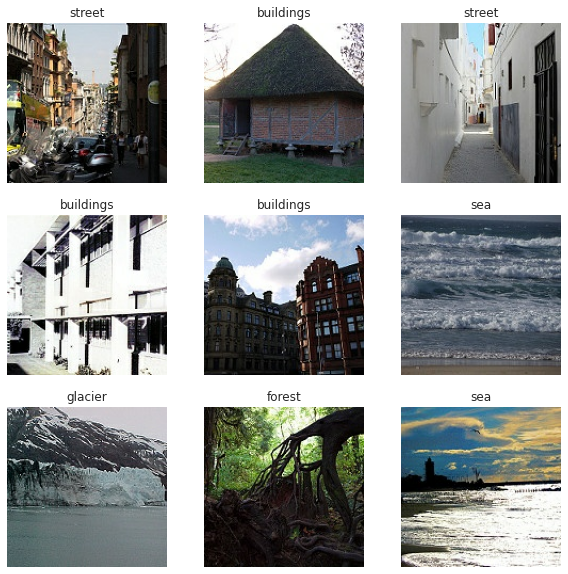

In [9]:
# Let's take a look at some sample images
image_labels =  ['buildings','forest','glacier','mountain','sea','street']
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    labels = np.array(labels)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(image_labels[np.argmax(labels[i])])
        plt.axis("off")
plt.savefig('./nb_images/sample_images.png')

In [10]:
# prefetching makes sure that the training and validation speeds are not constrained by disk I/O
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

### Performing classification with MobileNet_v2 as base model

We'll have to preprocess the input in-order to make sure it is in the format expected by the base model (in this case mobilenet_v2)

In [11]:
# Acts as a data preprocessing layer
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
# models expect channels to be explicitly speccified
IMG_SHAPE = IMG_SIZE + (3,)

# The base model for this case is the mobilenet v2. include_top = False says that we don't want to include the classification layer. (We'll make our own).
# We'll also keep the imagenet weights (what the model learned from the imagenet dataset)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9420800/9406464 [==============================] - 0s 0us/step


In [13]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2022-05-09 05:29:20.515600: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(32, 5, 5, 1280)


In [14]:
# We'll not change any weight in the base model at the beginning. We do so to give our new classification layer to (sync up?) with the base model.
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 75, 75, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

We did not  include the classification layer for the mobilenet_v2 architecture since we only need it as a feature extractor. We build our own classification layer that follows the base model. This is the part that most of our training will be focused on.

In [15]:
# Adding a global averaging layer after the base model. It averages each patch present in the feature map.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
# Final classification layer with 6 nodes (for 6 classes each followed by softmax activation.)
prediction_layer = tf.keras.layers.Dense(6,activation=('softmax'))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 6)


### Applying augmentation to the images to create a more varied training set and prevent overfitting

In [16]:
# The input images are subjected to the following changes in a random manner....horizontal flipping and rotation by 20 degrees
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(20),
])

### Putting the model together

In [17]:
# Putting together the defined layers
inputs = tf.keras.Input(shape=(150,150, 3)) # Input shape 
# add data augmentation
x = data_augmentation(inputs)
# Add preprocessing layer
x = preprocess_input(x)
# add base model
x = base_model(x, training=False)
# add global avg layer
x = global_average_layer(x)
# add dropout (drops the given ratio of nodes from previous layer randomly)
x = tf.keras.layers.Dropout(0.2)(x)
# Add final classification layer
outputs = prediction_layer(x)
model_mobilenet = tf.keras.Model(inputs, outputs)

In [18]:
# adding a model checkpointing callback
# saves the model weights that had the best validation accuracy so far during training
checkpoint_filepath = './checkpoints/mobilenet/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [19]:
# defining model hyperparameters
base_learning_rate = 0.0001
model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy',
                      tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall()
                      ])

In [20]:
model_mobilenet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 150, 150, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

Performing evaluation on validation set without training.

In [21]:
print(f'trainable variables - {len(model_mobilenet.trainable_variables)}')
loss0, accuracy0, auc0, precision0, recall0 = model_mobilenet.evaluate(val_ds)
# The model is completely untrained with the final layer having random weights. If you take a look, the accuracy is almost what you'll expect if you were to 
# classify randomly (100/6)

trainable variables - 2
132/132 [==============================] - 5s 25ms/step - loss: 2.5825 - accuracy: 0.1791 - auc: 0.5480 - precision: 0.2009 - recall: 0.1342


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial precision: {:.2f}".format(precision0))
print("initial recall: {:.2f}".format(recall0))
print("initial AUC-ROC: {:.2f}".format(auc0))

initial loss: 2.58
initial accuracy: 0.18
initial precision: 0.20
initial recall: 0.13
initial AUC-ROC: 0.55


Training the model for 10 epochs without altering the base model's weights. We want to train the classification layer based on these weights first before we unfreeze the entire model. This'll give the classification layer a chance to catch-up with the base model.

In [23]:
history = model_mobilenet.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds,
                   callbacks=[model_checkpoint_callback])

Epoch 1/10
307/307 [==============================] - 13s 34ms/step - loss: 1.4861 - accuracy: 0.4455 - auc: 0.7855 - precision: 0.5348 - recall: 0.3111 - val_loss: 0.8493 - val_accuracy: 0.6853 - val_auc: 0.9326 - val_precision: 0.7662 - val_recall: 0.5411
Epoch 2/10
307/307 [==============================] - 11s 36ms/step - loss: 0.8504 - accuracy: 0.6723 - auc: 0.9271 - precision: 0.7348 - recall: 0.5850 - val_loss: 0.6013 - val_accuracy: 0.7841 - val_auc: 0.9663 - val_precision: 0.8308 - val_recall: 0.6998
Epoch 3/10
307/307 [==============================] - 11s 35ms/step - loss: 0.7003 - accuracy: 0.7347 - auc: 0.9499 - precision: 0.7819 - recall: 0.6778 - val_loss: 0.5053 - val_accuracy: 0.8173 - val_auc: 0.9754 - val_precision: 0.8563 - val_recall: 0.7686
Epoch 4/10
307/307 [==============================] - 11s 36ms/step - loss: 0.6309 - accuracy: 0.7643 - auc: 0.9587 - precision: 0.8006 - recall: 0.7158 - val_loss: 0.4585 - val_accuracy: 0.8330 - val_auc: 0.9792 - val_precisi

### A curious point of note is that the validation accuracy is higher than training accuracy. 
Though this isn't a red-flag, it isn't ideal either. We expect to have a little overfitting in our model's results. The validation metrics are better than the training metrics mainly because layers like BatchNormalization and Dropout affect accuracy during training, however they are turned off when calculating validation loss.<br>
It can also be because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.<br>
This discrepency (if it can be called that) will be taken care of once we unfreeze the entire model.

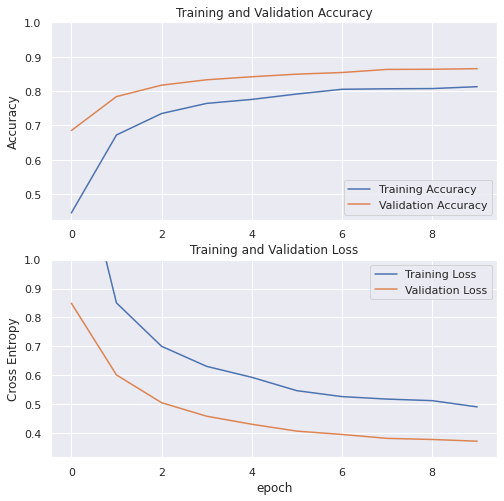

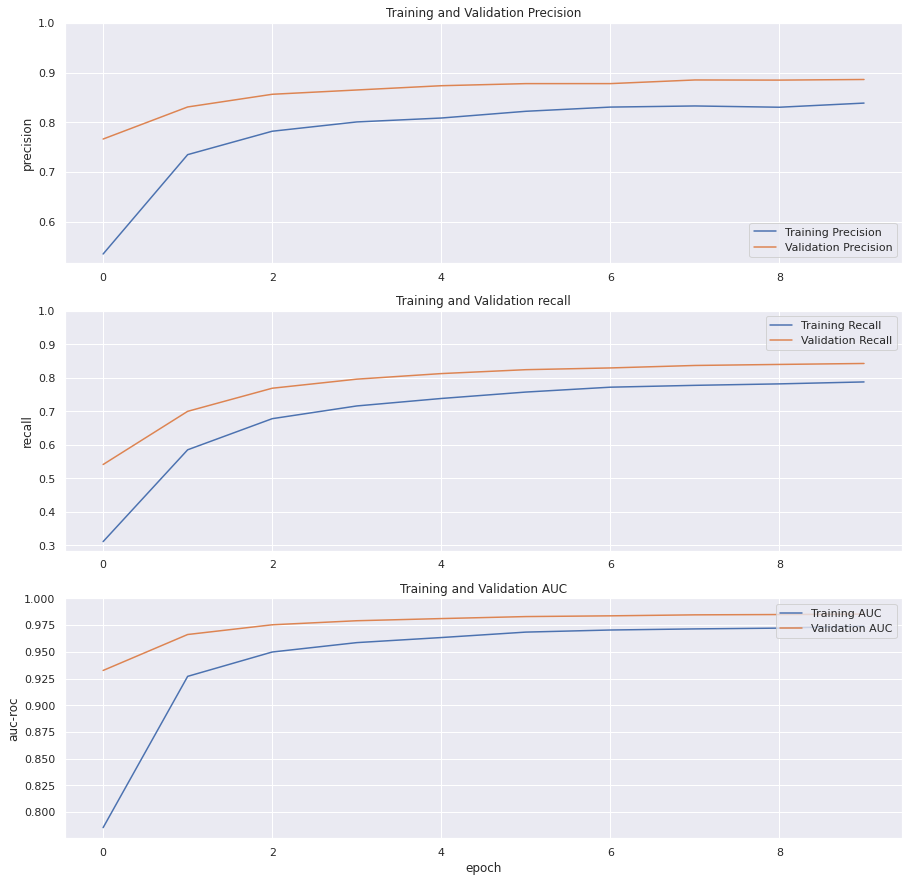

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

auc = history.history['auc']
val_auc = history.history['val_auc']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('./nb_images/accuracy and loss(round1).png')
plt.show()

plt.figure(figsize=(15,15))


plt.subplot(3, 1, 1)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('precision')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Precision')

plt.subplot(3, 1, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='upper right')
plt.ylabel('recall')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation recall')

plt.subplot(3, 1, 3)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.ylabel('auc-roc')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation AUC')


plt.xlabel('epoch')
plt.savefig('./nb_images/P_R_AUC(round1).png')
plt.show()

The layer from which we want the base model to be trained is a hyperparameter that might affect the performance of the model. Like other hyperparameters, this should be chosen wisely if optimal performance is a primary concern.

In [25]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [26]:
model_mobilenet.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy',
                      tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      ])

In [27]:
print(model_mobilenet.summary())
print(len(model_mobilenet.trainable_variables))

fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = model_mobilenet.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data=val_ds,
                        callbacks = [model_checkpoint_callback])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 150, 150, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

Note that the precision, recall and AUC values have '_1' at the end. This is because tensorflow/keras saves metrics such as precision etc. as variables which continue to exist even after the training of the model. So when we try to re-initialize the metric, it has to be saved under a different name.

In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

precision += history_fine.history['precision_1']
val_precision += history_fine.history['precision_1']

recall += history_fine.history['recall_1']
val_recall += history_fine.history['recall_1']

auc += history_fine.history['auc_1']
val_auc += history_fine.history['val_auc_1']

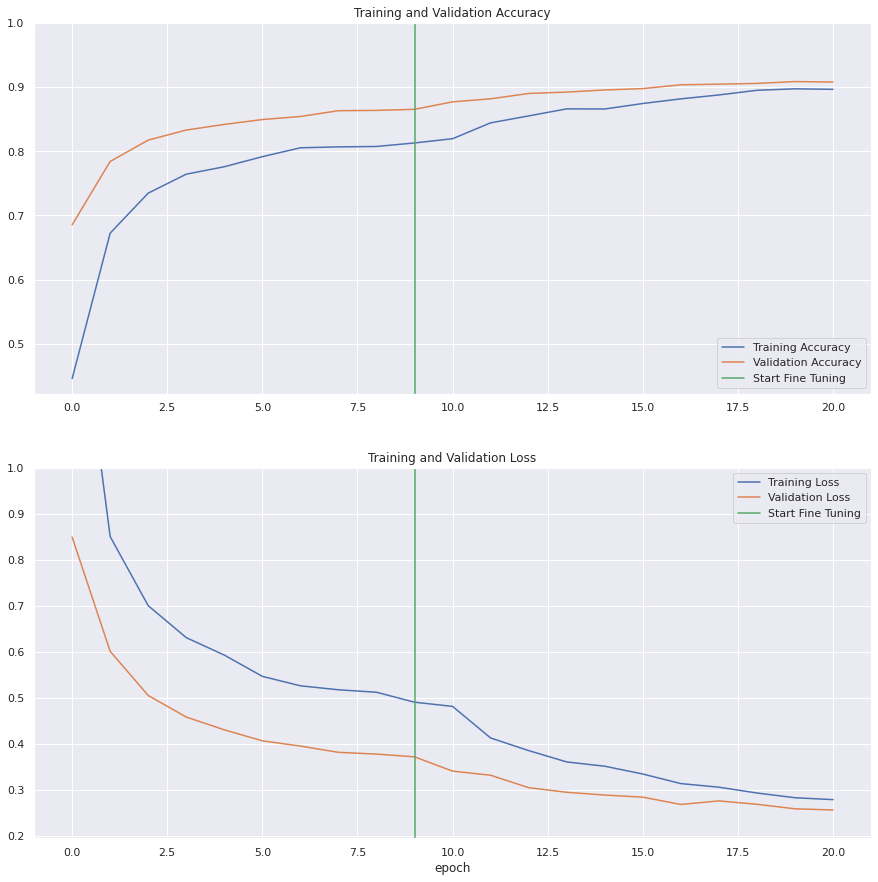

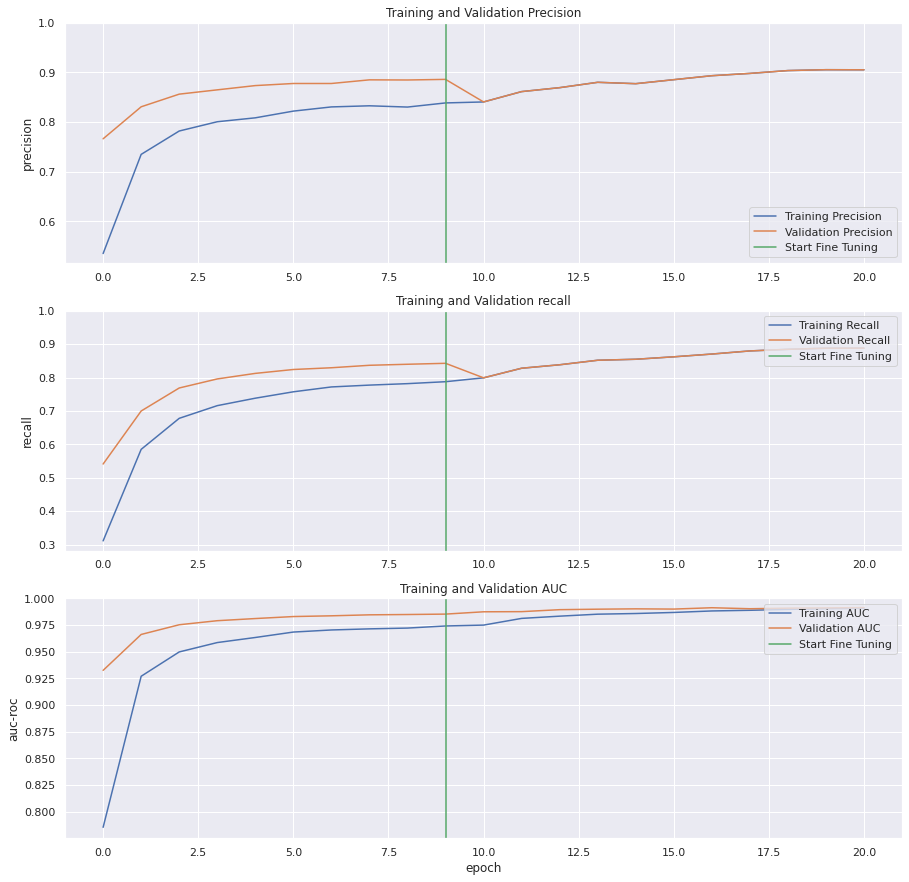

In [29]:
initial_epochs = 10
plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('./nb_images/Accuracy and loss(round2_mobilenet).png')
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(3, 1, 1)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.ylabel('precision')
plt.title('Training and Validation Precision')

plt.subplot(3, 1, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('recall')
plt.title('Training and Validation recall')

plt.subplot(3, 1, 3)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('auc-roc')
plt.title('Training and Validation AUC')


plt.xlabel('epoch')
plt.savefig('./nb_images/P_R_AUC(round2_mobilenet).png')
plt.show()


In [30]:
# final evaluation on test set
loss_mob, accuracy_mob, precision_mob, recall_mob, auc_mob = model_mobilenet.evaluate(test_ds)
print('Test accuracy :', accuracy_mob)
print('Test Precision :', precision_mob)
print('Test Recall :', recall_mob)
print('Test AUC :', auc_mob)

94/94 [==============================] - 9s 95ms/step - loss: 0.2609 - accuracy: 0.9050 - auc_1: 0.9914 - precision_1: 0.9124 - recall_1: 0.8993
Test accuracy : 0.9049999713897705
Test Precision : 0.9913703203201294
Test Recall : 0.9124112129211426
Test AUC : 0.8993333578109741


In [31]:
y_pred = []
y_true = []
for im_batch,label_batch in test_ds:
    y_true.append(tf.argmax(label_batch,axis=-1))
    y_pred.append(tf.argmax(model_mobilenet.predict(im_batch),axis=-1))

In [32]:
# Copied from sklearn documentation
def plot_confusion_matrix(cm, classes, name, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()


    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.grid(b=None)
    plt.ylabel('True label')

    plt.xlabel('Predicted label')
    plt.savefig(f'./nb_images/confusion_matrix_{name}.png')

In [33]:
y_true = tf.concat([item for item in y_true],axis=0)
y_pred = tf.concat([item for item in y_pred],axis=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


Normalized confusion matrix


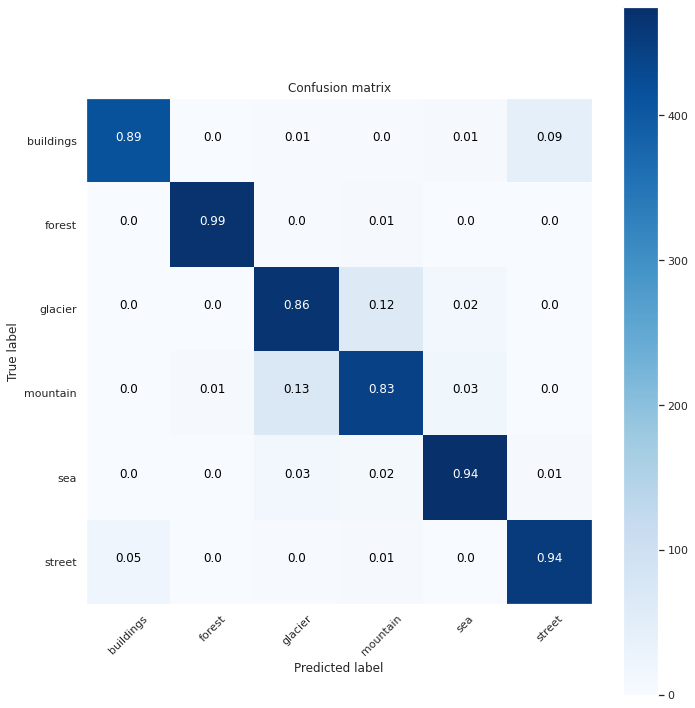

In [34]:
target_classes = ['buildings','forest','glacier','mountain','sea' ,'street' ]
cm = confusion_matrix(y_pred,y_true)
plot_confusion_matrix(cm,target_classes,name='mobilenet_v2')

The highest number of inaccurate classifications is among glacier and mountain classes. Same for street and buildings classes.

In [35]:
!mkdir ./models

In [36]:
#saving the model
model_mobilenet.save('./models/model_mobilenet.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Transfer Learning with VGG16

Previously, we saw the results with MobileNet_v2 as the base model. This time we'll use a pretrained VGG16 as the base model. The VGG16 is also trained on imagenet weights. We'll also introduce some additional augmentations and tweak the hyperparameters a little bit.

In [37]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [38]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

Defining the global average pooling layers and final classification layer.

In [39]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 512)


In [40]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(6,activation=('softmax'))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 512)
(32, 6)


Data Augmentations applied are as follows - Images are randomly flipped horizontally and vertically, randomly rotated by 30 degrees. Images are randomly shifted and contrast is tandomly applied. The reader is encouraged to experiment with different transformations and see if the results improve.

In [41]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomFlip('vertical'),
  tf.keras.layers.RandomRotation(30),
   tf.keras.layers.RandomTranslation(height_factor=(-0.2,0.3),width_factor = (-0.2,0.3)),
    tf.keras.layers.RandomContrast(factor=0.2)
])

In [42]:
inputs = tf.keras.Input(shape=(150,150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.35)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [43]:
base_learning_rate = 0.0002
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy',
                      tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      ])

In [44]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 150, 150, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0   

In [45]:
loss0, accuracy0, auc0, precision0, recall0 = model.evaluate(val_ds)

132/132 [==============================] - 8s 44ms/step - loss: 9.5631 - accuracy: 0.2033 - auc_2: 0.5156 - precision_2: 0.2054 - recall_2: 0.1998


In [46]:
EPOCHS=20
checkpoint_filepath = './checkpoints/checkpoints_vgg16/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
# Model weights are saved at the end of every epoch, if it's the best performing model so far.
history = model.fit(train_ds, validation_data = val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback])
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Epoch 1/20
307/307 [==============================] - 19s 56ms/step - loss: 6.4682 - accuracy: 0.2818 - auc_2: 0.6115 - precision_2: 0.2845 - recall_2: 0.2713 - val_loss: 3.3986 - val_accuracy: 0.4751 - val_auc_2: 0.7760 - val_precision_2: 0.4807 - val_recall_2: 0.4672
Epoch 2/20
307/307 [==============================] - 18s 58ms/step - loss: 3.6412 - accuracy: 0.4644 - auc_2: 0.7633 - precision_2: 0.4728 - recall_2: 0.4548 - val_loss: 1.6022 - val_accuracy: 0.6708 - val_auc_2: 0.8953 - val_precision_2: 0.6766 - val_recall_2: 0.6629
Epoch 3/20
307/307 [==============================] - 17s 57ms/step - loss: 2.5936 - accuracy: 0.5674 - auc_2: 0.8318 - precision_2: 0.5759 - recall_2: 0.5585 - val_loss: 1.2182 - val_accuracy: 0.7394 - val_auc_2: 0.9265 - val_precision_2: 0.7454 - val_recall_2: 0.7342
Epoch 4/20
307/307 [==============================] - 18s 57ms/step - loss: 2.1010 - accuracy: 0.6200 - auc_2: 0.8630 - precision_2: 0.6267 - recall_2: 0.6099 - val_loss: 0.9306 - val_accura

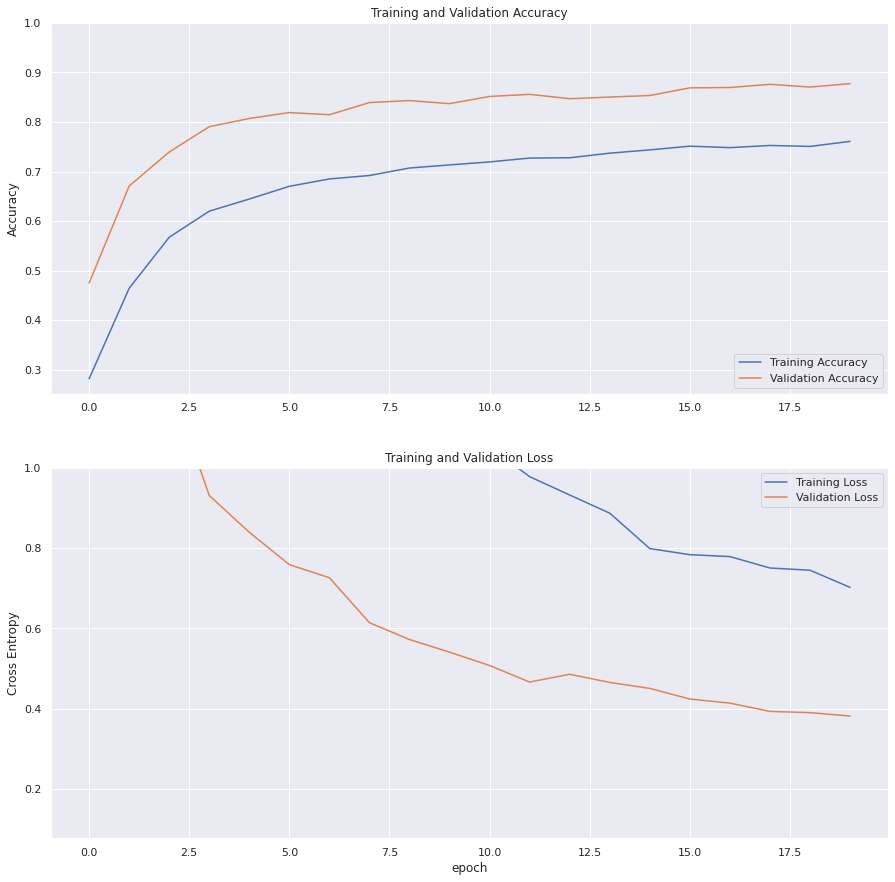

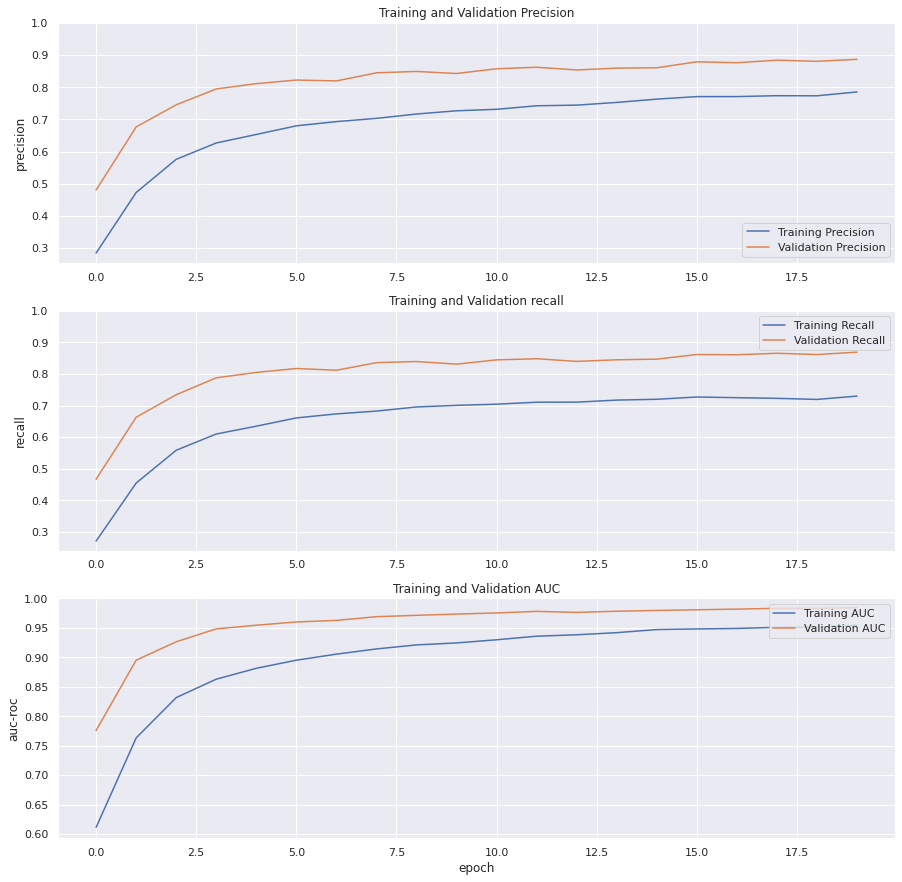

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

precision = history.history['precision_2']
val_precision = history.history['val_precision_2']

recall = history.history['recall_2']
val_recall = history.history['val_recall_2']

auc = history.history['auc_2']
val_auc = history.history['val_auc_2']

plt.figure(figsize=(15,15))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('./nb_images/accuracy and loss(round1_vgg16).png')
plt.show()

plt.figure(figsize=(15,15))


plt.subplot(3, 1, 1)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('precision')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Precision')

plt.subplot(3, 1, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='upper right')
plt.ylabel('recall')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation recall')

plt.subplot(3, 1, 3)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.ylabel('auc-roc')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation AUC')


plt.xlabel('epoch')
plt.savefig('./nb_images/P_R_AUC(round1_vgg16).png')
plt.show()

In [48]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [49]:
# Fine-tune from this layer onwards
fine_tune_at = 8 #randomly selected hyperparameter

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [50]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy',
                      tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      ])
print(model.summary())
print(len(model.trainable_variables))

fine_tune_epochs = 15
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                        callbacks=[model_checkpoint_callback])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 150, 150, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0   

In [51]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

precision += history_fine.history['precision_3']
val_precision += history_fine.history['precision_3']

recall += history_fine.history['recall_3']
val_recall += history_fine.history['recall_3']

auc += history_fine.history['auc_3']
val_auc += history_fine.history['val_auc_3']

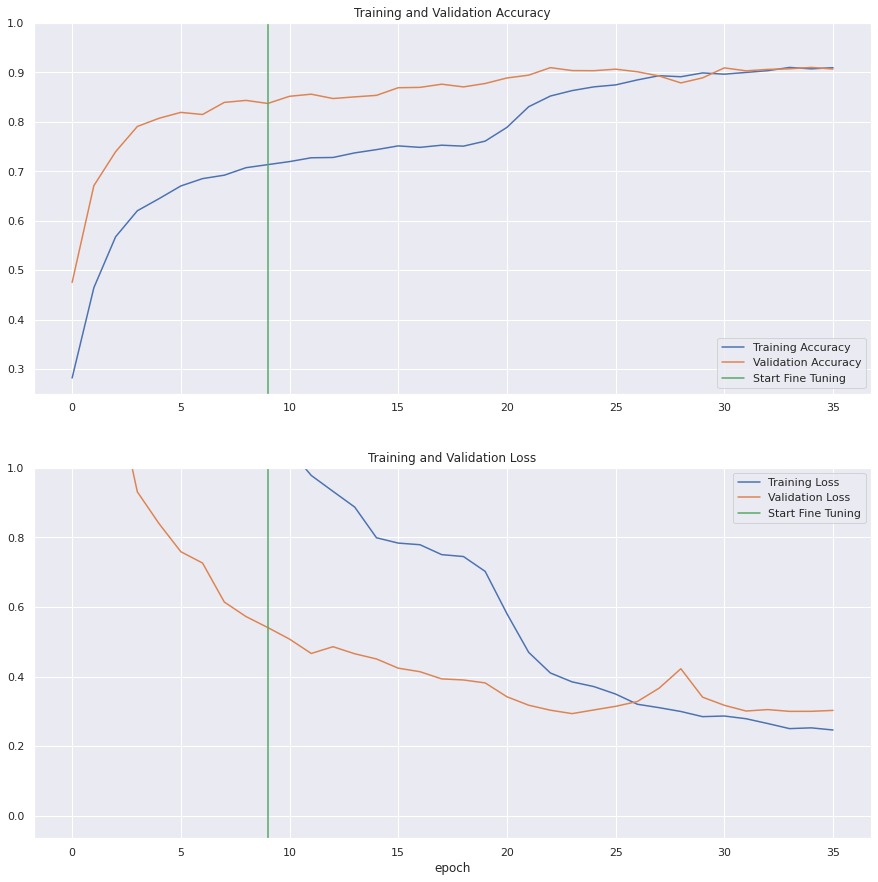

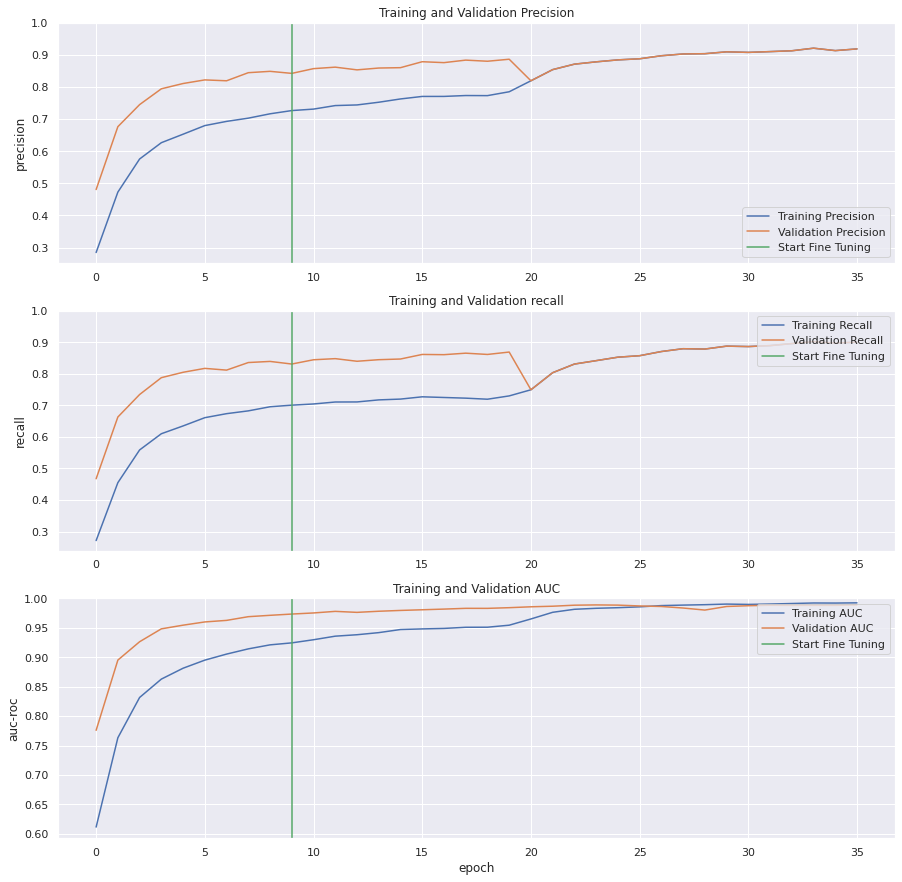

In [52]:
initial_epochs = 10
plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('./nb_images/Accuracy and loss(round2_vgg).png')
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(3, 1, 1)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.ylabel('precision')
plt.title('Training and Validation Precision')

plt.subplot(3, 1, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('recall')
plt.title('Training and Validation recall')

plt.subplot(3, 1, 3)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('auc-roc')
plt.title('Training and Validation AUC')


plt.xlabel('epoch')
plt.savefig('./nb_images/P_R_AUC(round2_vgg).png')
plt.show()

In [53]:
loss_vgg, accuracy_vgg, precision_vgg, recall_vgg, auc_vgg = model.evaluate(test_ds)
print('Test accuracy :', accuracy_vgg)
print('Test Precision :', precision_vgg)
print('Test Recall :', recall_vgg)
print('Test AUC :', auc_vgg)

94/94 [==============================] - 5s 48ms/step - loss: 0.3048 - accuracy: 0.9067 - auc_3: 0.9881 - precision_3: 0.9110 - recall_3: 0.9047
Test accuracy : 0.9066666960716248
Test Precision : 0.9880555272102356
Test Recall : 0.9110440015792847
Test AUC : 0.9046666622161865


In [54]:
y_pred = []
y_true = []
for im_batch,label_batch in test_ds:
    y_true.append(tf.argmax(label_batch,axis=-1))
    y_pred.append(tf.argmax(model.predict(im_batch),axis=-1))
    
y_true = tf.concat([item for item in y_true],axis=0)
y_pred = tf.concat([item for item in y_pred],axis=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


Normalized confusion matrix


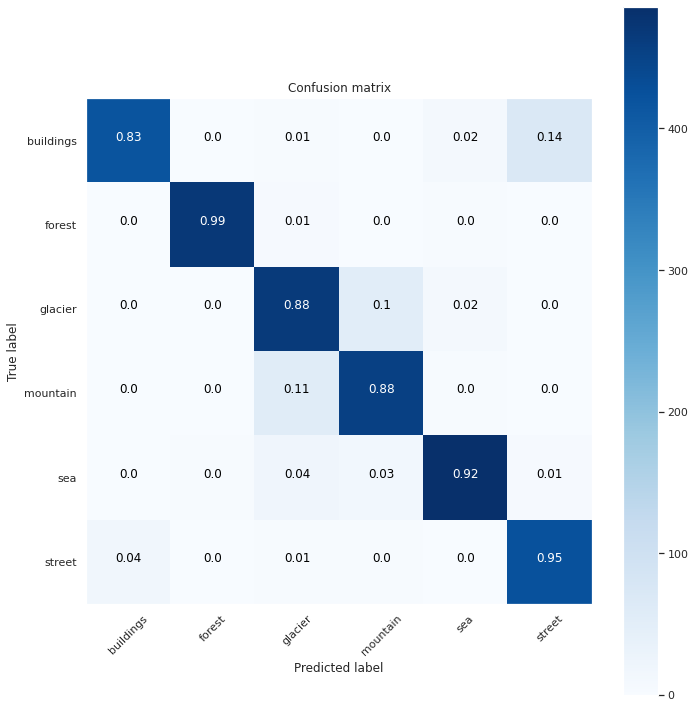

In [55]:
target_classes = ['buildings','forest','glacier','mountain','sea' ,'street' ]
cm = confusion_matrix(y_pred,y_true)
plot_confusion_matrix(cm,target_classes,name='vgg16')

In [56]:
model.save('./models/model_vgg16.h5')

### Comparing between the two classifiers
Note here that although the following comparison might seem to be based mainly on the choice of base model, there are a lot of other factors such as choice of hyperparameters, data augmentation etc that affect the models' performances on different metrics. Hyperparameter tuning is a broad topic in and itself and therefore it isn't explored here in much depth.

In [57]:
mobilenet_metrics = [accuracy_mob,loss_mob,precision_mob,recall_mob,auc_mob]
vgg_metrics = [accuracy_vgg,loss_vgg,precision_vgg,recall_vgg,auc_vgg]

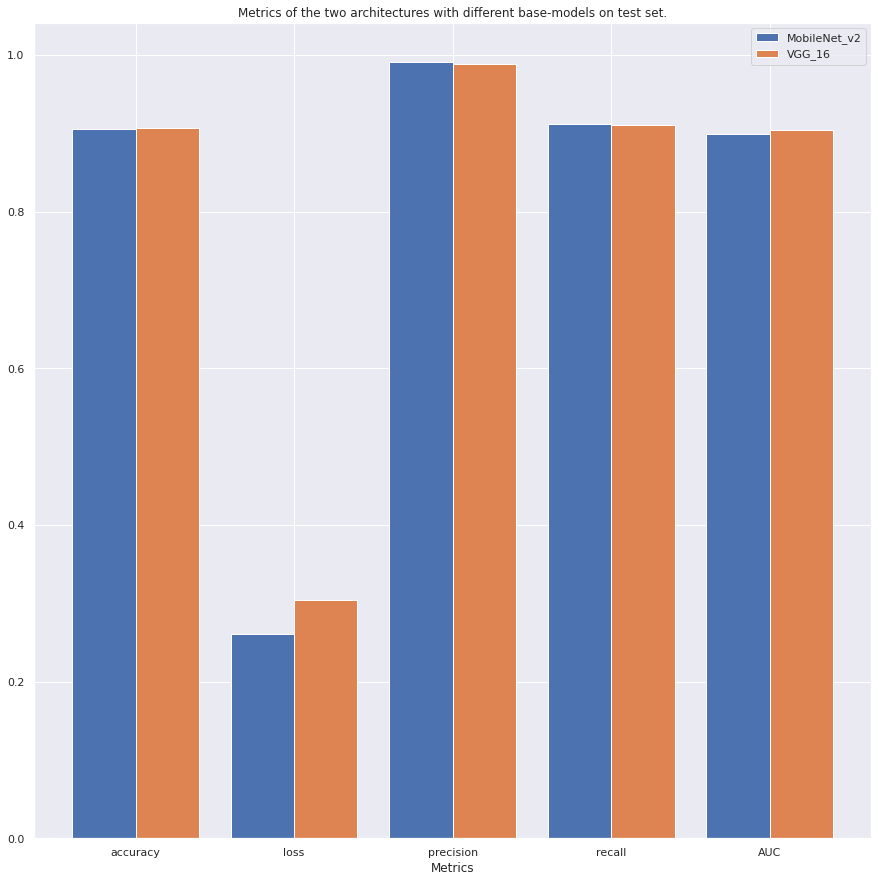

In [58]:
X = ['accuracy','loss','precision','recall','AUC']
X_axis = np.arange(len(X))
plt.figure(figsize=(15,15))
plt.bar(X_axis - 0.2, mobilenet_metrics, 0.4, label = 'MobileNet_v2')
plt.bar(X_axis + 0.2, vgg_metrics, 0.4, label = 'VGG_16')
  
plt.xticks(X_axis, X)
plt.xlabel("Metrics")
plt.title("Metrics of the two architectures with different base-models on test set.")
plt.legend()
plt.savefig('final_comparison_intel_image.png')
plt.show()

In [59]:
shutil.make_archive('images', 'zip', './nb_images')
shutil.make_archive('models', 'zip', './models')

'/kaggle/working/models.zip'